In [1]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import glob
from tqdm.auto import tqdm
import country_converter as coco
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

2025-10-08 20:15:32.988 | INFO     | artifacts_ipv6_sra_scanning.config:<module>:22 - PROJ_ROOT path is: /home/service/artifacts-ipv6-sra-scanning


In [2]:
import polars as pl
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

In [3]:
def side_by_side(*dfs,to_pandas=True):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        if to_pandas:
            html += df.to_pandas().to_html()
        else:
            html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

In [4]:
figsize_small = (8 * 0.7, 4 * 0.5)
figsize_small_with_legend_on_top = (8 * 0.7, 5 * 0.5)
figsize_medium = (8 * 0.7, 5.5 * 0.5)
figsize_wide = (14 * 0.7, 5 * 0.5)

In [5]:
df_scan01 = pl.read_csv(f'{RAW_DATA_DIR}/bgp48_1728075185_routerIP_stats.csv',separator=';')
df_scan01 = df_scan01.rename({"ASN": "AS-Number",'numamplsubnets_48':'numamplsubnets','numsubnets_48':'numsubnets','Prefix':'BGP-Prefix','routerip':'saddr'})

In [6]:
df_scan02 = pl.read_parquet(f'{PROCESSED_DATA_DIR}/icmp-bgp48-all/zmap_log_2025-04-02T09_17_15+00_00.log_processed_withInfo')

In [7]:
# new bgp data
df_scan03 = pl.read_parquet(f'{PROCESSED_DATA_DIR}/icmp-bgp48-all/zmap_log_2025-04-02T21_19_41+00_00.log_processed_withInfo')

In [8]:
# filter any data that has no ASN and no country code
# edit: removes 6-7M routing loops, so we leave it as is for now
#df_scan01 = df_scan01.filter((~pl.col('Geo').is_null()) & (~pl.col('AS-Number').is_null()))
#df_scan02 = df_scan02.filter((~pl.col('Geo').is_null()) & (~pl.col('AS-Number').is_null()))
#df_scan03 = df_scan03.filter((~pl.col('Geo').is_null()) & (~pl.col('AS-Number').is_null()))

In [9]:
pd_df = df_scan01.filter((pl.col('numamplsubnets')>0) & (pl.col('classification')=='timxceed')).sort('maxampl',descending=True).to_pandas()
loop_df = df_scan01.filter((pl.col('classification')=='timxceed')).sort('numsubnets',descending=True).to_pandas()

In [10]:
totalloops = df_scan01.filter((pl.col('classification')=='timxceed'))['numsubnets'].sum()
#print(
df_scan01.filter((pl.col('classification')=='timxceed') & (pl.col('Geo').is_not_null())).group_by(['Geo']).agg(
    pl.col('numsubnets').sum().alias('routingloops'),
    (pl.col('numsubnets').sum()/totalloops).mul(100).alias('relative'),
    pl.col('saddr').n_unique().alias('routerips'),
).top_k(5,by='routingloops').to_pandas()#.to_latex(index=False,float_format="%.2f"))

,Geo,routingloops,relative,routerips
0,BRA,37081970,26.222086,9329
1,DEU,13273666,9.386319,1192
2,CZE,10444197,7.385493,881
3,USA,7613551,5.383835,4150
4,NLD,7241713,5.120894,388


In [11]:
totalloops = df_scan01.filter((pl.col('classification')=='timxceed'))['numsubnets'].sum()
df_scan01.filter((pl.col('classification')=='timxceed') & (pl.col('Geo').is_not_null())).group_by(['Geo']).agg(
    pl.col('numsubnets').sum().alias('routingloops'),
    (pl.col('numsubnets').sum()/totalloops).mul(100).alias('relative'),
    pl.col('saddr').n_unique().alias('routerips'),
).top_k(5,by='routingloops')['relative'].sum()

53.49862680080404

In [12]:
totalamp = df_scan01.filter((pl.col('classification')=='timxceed') & (pl.col('numamplsubnets')>0))['numsubnets'].sum()
#print(
df_scan01.filter((pl.col('classification')=='timxceed') & (pl.col('Geo').is_not_null()) & (pl.col('numamplsubnets')>0)).group_by(['Geo']).agg(
    pl.col('numamplsubnets').sum().alias('amplification'),
    (pl.col('numamplsubnets').sum()/totalamp).mul(100).alias('relative'),
    pl.col('saddr').n_unique().alias('routerips'),
    pl.col('maxampl').max().alias('maxamplification'),
).top_k(5,by='amplification').to_pandas()#.to_latex(index=False,float_format="%.2f"))

,Geo,amplification,relative,routerips,maxamplification
0,BRA,4674687,23.351353,2765,51
1,DEU,477046,2.382977,78,258399
2,USA,247736,1.237510,577,109385
3,CHN,245546,1.226570,4141,52
4,CZE,212547,1.061731,17,37


In [13]:
plt.rc("font", size=12)

<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_953793/2630728702.py:13: SyntaxWarning: invalid escape sequence '\g'
  ax.text(2000,0.1*10**4,"Amplification\n$\geq$10 (0.2%)",color='grey',horizontalalignment='center')


/home/service/artifacts-ipv6-sra-scanning/reports/figures/amplification-routingloops.png


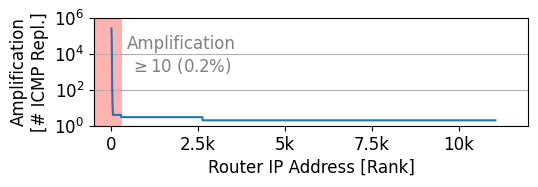

In [24]:
fig,ax = vh.fig_ax(figsize=(8*0.7,2*0.7))
pd_df.plot(y='maxampl',ax=ax,legend=False)
ax.set_yscale('log')
ax.set_ylim(1,10**6)
ax.set_xlim(-500,12000)
ax.grid(axis='y')
ax.set_ylabel('Amplification\n[# ICMP Repl.]')
ax.set_xlabel('Router IP Address [Rank]')

ax.set_xticks([0,2500,5000,7500,10000],['0','2.5k','5k','7.5k','10k'])

ax.axvspan(-500,300,facecolor='red',alpha=0.3)
ax.text(2000,0.1*10**4,"Amplification\n$\geq$10 (0.2%)",color='grey',horizontalalignment='center')
vh.save_plot(fig,'amplification-routingloops')

In [15]:
loop_df['AS-Number'].nunique()

5531

In [16]:
len(loop_df[loop_df.numsubnets==1])/len(loop_df)

0.604160816250117

/home/service/artifacts-ipv6-sra-scanning/reports/figures/looping-subnets-per-router-rank.png


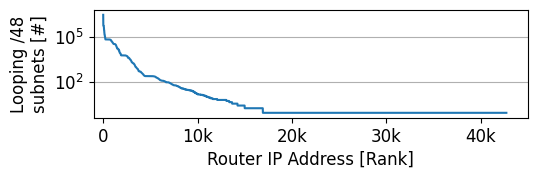

In [18]:
fig,ax = vh.fig_ax(figsize=(8*0.7,2*0.7))
loop_df.plot(y='numsubnets',ax=ax,legend=False)
ax.set_yscale('log')
#ax.set_ylim(0,10**7.2)
#ax.set_ylim(0.15,10**6.4)
ax.set_xlim(-1000,45000)
ax.grid(axis='y')
ax.set_ylabel('Looping /48\nsubnets [#]')
ax.set_xlabel('Router IP Address [Rank]')

ax.set_xticks([0,10000,20000,30000,40000],['0','10k','20k','30k','40k'])

#ax.set_yticks([])
#ax.set_yticks([0,10**1,10**3,10**5,10**7])

#ax.axvspan(-100,166,facecolor='red',alpha=0.3)
#ax.text(1000,3*10**4,"Amplification\n$\geq$10 (2.3%)",color='grey',horizontalalignment='center')
vh.save_plot(fig,'looping-subnets-per-router-rank')